In [8]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Splitting the raw TXT file.

In [9]:
#DO NOT RUN IF YOU DO NOT WANT TO GENERATE NEW DATA Loadinf of the main EP dataset
#data_path = './MindBigData-EP-v1.0/EP1.01.txt'
#split_main_data(data_path=data_path, output_folder='./MindBigData-EP-v1.0')

Load the files, get the points and the list of labels

In [10]:
files = glob.glob('./Datasets/MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=len(files), ignore=[-1, 10]) #first_n = 500 by default. Apply first_n = len(files) to load all

Loading epoc data...


100%|██████████| 65034/65034 [01:55<00:00, 564.74it/s]


In [11]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Num points EPOC: 64470
Num labels EPOC: 10
Labels EPOC: ['1', '9', '0', '5', '2', '4', '8', '7', '3', '6']
------------------------------------
Data shape EPOC (14, 256)


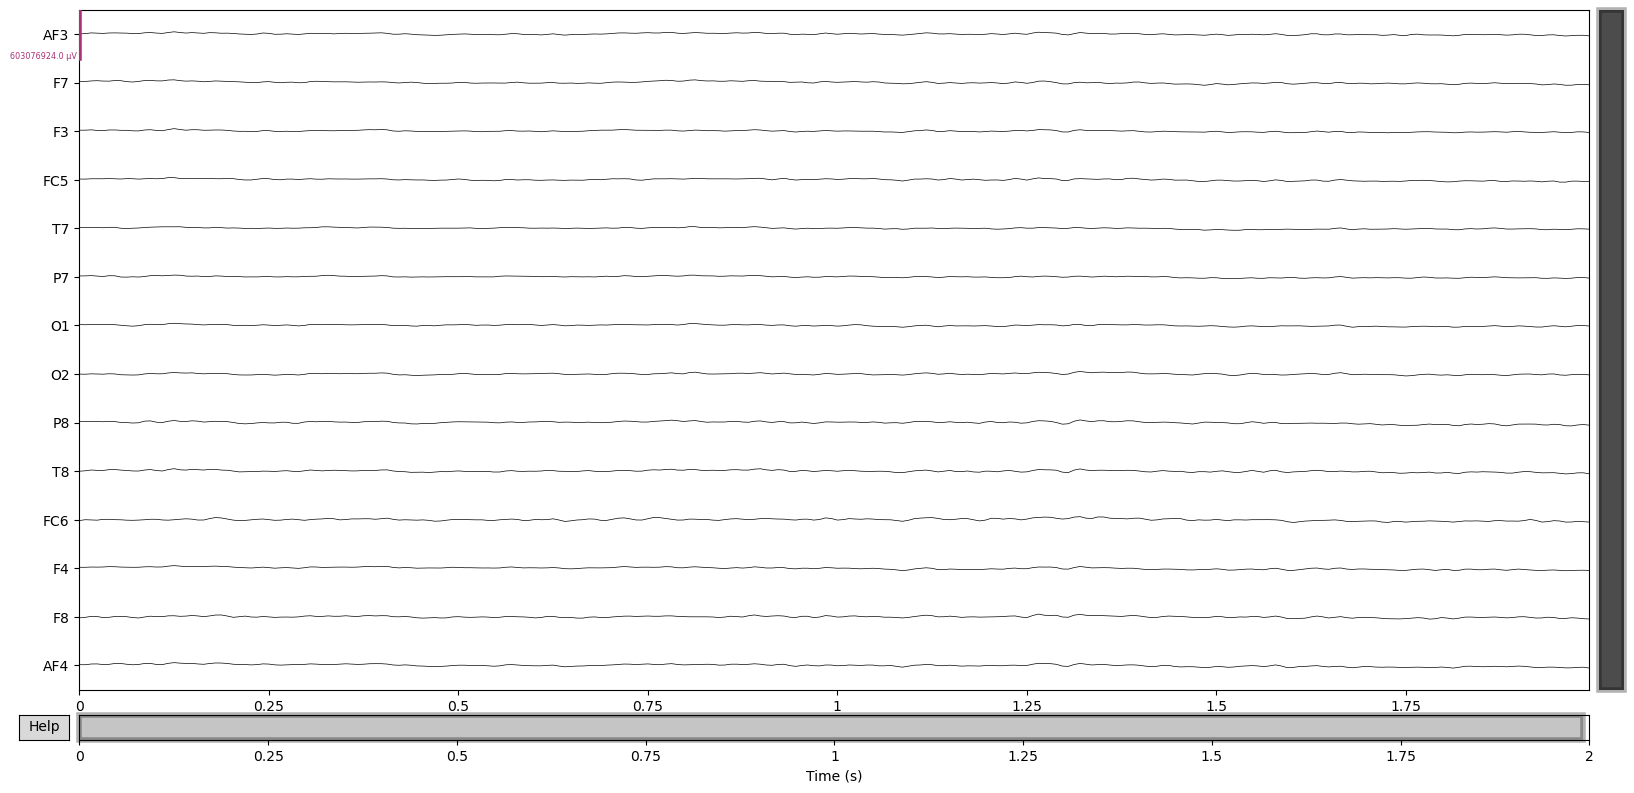

In [12]:
all_points[0].mne_object.plot(scalings = 'auto');

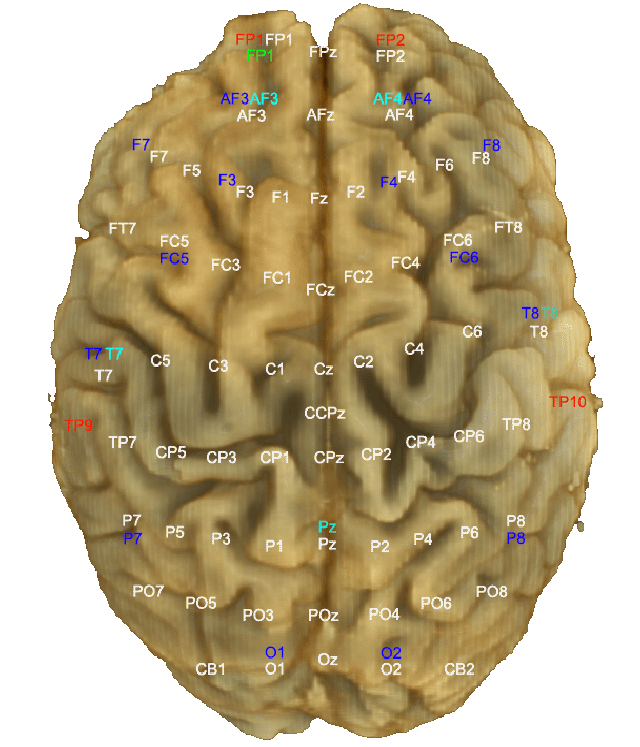

Epoc channels:---"AF3","AF4","T7","T8","P7", "F7", "F3", "FC5", "O1", "O2", "P8",  "FC6", "F4", "F8",

One paper states that best results came from 'T7', 'P7', 'P8', 'T8'

In [13]:
"""
We will loop through every data point and call the cleaning methods.
This filters the frequencies to be only between the ranges. We want 3 - 30 because this is where relevant alpha theta, beta bands lie.
MNE says to multiply the lowpass by 1/3.
"""
print("Cleaning epoc....")
for point in tqdm(all_points):
    point.full_clean(channels = ['T7', 'P7', 'P8', 'T8'], l_freq = 3, h_freq = 30)


Cleaning epoc....


100%|██████████| 64470/64470 [03:48<00:00, 281.73it/s]


Checking if there is statistically a difference between samples

In [14]:
data = {
    0:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },
    1:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },
    2:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },
    3:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },
    4:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },
    5:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },
    6:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },
    7:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },
    8:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },
    9:{
        'T7':[],
        'T8':[],
        'P7':[],
        'P8':[],
    },

}

for point in tqdm(all_points):
    label = int(point.label)
    t7_index = point.ch_names.index('T7')
    t8_index = point.ch_names.index('T8')
    p7_index = point.ch_names.index('P7')
    p8_index = point.ch_names.index('P8')

    data[label]['T7'] += list(point.raw_data[t7_index])
    data[label]['T8'] += list(point.raw_data[t8_index])
    data[label]['P7'] += list(point.raw_data[p7_index])
    data[label]['P8'] += list(point.raw_data[p8_index])



100%|██████████| 64470/64470 [00:03<00:00, 19162.40it/s]


In [15]:
#Null, same mean

from scipy import stats

print('If no verbose, all channels are signiifically different')
for label_a in data:
    for label_b in data:
        if label_b == label_a:
            continue
        not_different = []
        for channel in ['T7', 'T8', 'P7', 'P8']:
            sample_a = np.array(data[label_a][channel])
            sample_b = np.array(data[label_b][channel])

            r = stats.ttest_ind(sample_a, sample_b, equal_var=False)
            if(r.pvalue >= 0.05):
                not_different.append(channel)
        if len(not_different) != 0:
            print(f"\nTesting: {label_a} vs {label_b}\nThe following channels are similar: {not_different}")

print("done")

If no verbose, all channels are signiifically different

Testing: 0 vs 1
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 0 vs 2
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 0 vs 3
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 0 vs 4
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 0 vs 5
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 0 vs 6
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 0 vs 7
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 0 vs 8
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 0 vs 9
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 1 vs 0
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 1 vs 2
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing: 1 vs 3
The following channels are similar: ['T7', 'T8', 'P7', 'P8']

Testing

Code for normalization. Should fit train, and apply to all. Note that normalization should not be applied before interpolating data.

In [16]:
"""from EegHelper.EegAugmentation import NormalizationHelper

helper = NormalizationHelper(all_points)           #Provide the data which you want to fit with
scaler = helper.get_robust_scaler()              #Get the fit scaler
all_points = NormalizationHelper.fit_points(scaler=scaler,data_points=all_points) #Fit points after providing scaler"""

'from EegHelper.EegAugmentation import NormalizationHelper\n\nhelper = NormalizationHelper(all_points)           #Provide the data which you want to fit with\nscaler = helper.get_robust_scaler()              #Get the fit scaler\nall_points = NormalizationHelper.fit_points(scaler=scaler,data_points=all_points) #Fit points after providing scaler'

In [17]:
from EegHelper.EegAugmentation import CorrelationHelper

https://ieeexplore.ieee.org/document/9616192/citations#citations

In [18]:
print(all_points[0].mne_object.ch_names.index('T8'))
print(all_points[1].mne_object.ch_names.index('T8'))
print(all_points[2].mne_object.ch_names.index('T8'))
print(all_points[3].mne_object.ch_names.index('T8'))

3
3
3
3


Loads the corelation helpers with all nececarry data. Only perform these tasks if data has not been normalized.

In [19]:
helpers =  [[-1 for _ in range(4)] for _ in range(len(all_labels))]
"""
  chanel
   -----------
l| ch
a|
b|
e|
l|
"""

for point in all_points:
    for channel in point.mne_object.ch_names:
        ch_index = point.mne_object.ch_names.index(channel)
        if(helpers[int(point.label)][ch_index] == -1):
            helpers[int(point.label)][ch_index] = CorrelationHelper(point.label, channel)
        
        helpers[int(point.label)][ch_index].add_point(
            point.mne_object._data[ch_index,:]
        )

Measures the corellation coefficient of all points channels, stores the results in point.scores

In [20]:
for point in tqdm(all_points):
    for channel in point.mne_object.ch_names:
        ch_index = point.mne_object.ch_names.index(channel)
        helper = helpers[int(point.label)][ch_index]

        mean = helper.mean()
        d = helper.d()

        sample = point.raw_data[ch_index]

        numer = d*np.sum(sample*mean) - np.sum(sample)*np.sum(mean)
        denom = (d*np.sum(sample*sample) - np.power(np.sum(sample),2)) * ((d*np.sum(mean*mean)) - np.power(np.sum(mean), 2))
        z = numer/np.sqrt(denom)

        point.scores[ch_index] = abs(z)

100%|██████████| 64470/64470 [19:00<00:00, 56.51it/s]


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

a, b, c, d = [], [], [], []
all_scores = []

a_name = all_points[0].ch_names[0]
b_name = all_points[0].ch_names[1]
c_name = all_points[0].ch_names[2]
d_name = all_points[0].ch_names[3]

for point in all_points:
    scores = point.scores
    a.append(scores[0])
    b.append(scores[1])
    c.append(scores[2])
    d.append(scores[3])

In [22]:
print("Mean of all:", np.mean(a+b+c+d))
print("STD of all:", np.std(a+b+c+d))
print("==================================================")
print(f"Mean of {a_name}:", np.mean(a))
print(f"STD of {a_name}:", np.std(a))
print("==================================================")
print(f"Mean of {b_name}:", np.mean(b))
print(f"STD of {b_name}:", np.std(b))
print("==================================================")
print(f"Mean of {c_name}:", np.mean(c))
print(f"STD of {c_name}:", np.std(c))
print("==================================================")
print(f"Mean of {d_name}:", np.mean(d))
print(f"STD of {d_name}:", np.std(d))

Mean of all: 0.12408201364831421
STD of all: 0.09527155807461599
Mean of T7: 0.10710971079466614
STD of T7: 0.0833230358140334
Mean of P7: 0.147208265997155
STD of P7: 0.10665393492736583
Mean of P8: 0.14646304411221495
STD of P8: 0.10108812486557697
Mean of T8: 0.09554703368922074
STD of T8: 0.07504693046696599


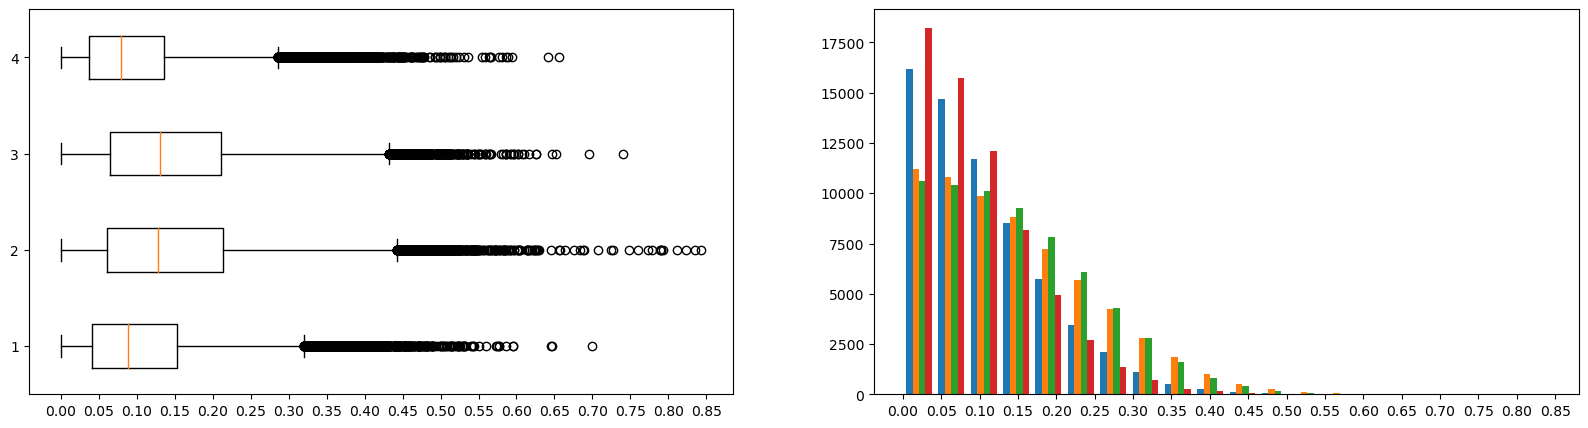

In [23]:
import matplotlib.ticker as ticker

_, axes = plt.subplots(1, 2, figsize=(20, 5))

i = axes[0].boxplot((a, b, c, d), vert=False)
i = axes[1].hist((a, b, c, d), bins = 20)

tick_spacing = 0.05
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

In [24]:
good_points = []
for point in all_points:
    if(len(point.scores) > 4):
        point.scores = point.scores[0:4]
    above_thresh = 0
    for score in point.scores:
        if score > 0.1:
            above_thresh += 1
    if above_thresh > 2:
       good_points.append(point)

In [25]:
print(len(good_points))
print(len(all_points))

21965
64470


In [26]:
"""
Marks bad channels
"""
for point in good_points:
    for i, channel in enumerate(point.ch_names):
        if point.scores[i] < 0.1:
            point.mne_object.info['bads'].append(channel)

In [27]:
for point in tqdm(good_points):
    point.interpolate_bad_channels()

100%|██████████| 21965/21965 [02:17<00:00, 160.30it/s]


In [29]:
from EegHelper.EegData import data_points_to_file, load_file

data_points_to_file(good_points, './Datasets/Interpolated_Clean_Data2')

In [30]:
import pandas as pd

Loading cleaned data

In [31]:
files = glob.glob('./Interpolated_Clean_Data/*.csv')
points_test, labels = files_to_datapoints(files, first_n=500)

Loading epoc data...


0it [00:00, ?it/s]
